In [52]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
import hackeeg
from hackeeg import ads1299

In [53]:
SERIAL_PORT_PATH = "/dev/cu.usbmodem143301"
SAMPLES_PER_SECOND = ads1299.HIGH_RES_1k_SPS
GAIN = ads1299.GAIN_4X
CHANNELS = 8

In [54]:
# Configure ADS1299
hackeeg = hackeeg.HackEEGBoard(serial_port_path=SERIAL_PORT_PATH)
hackeeg.connect()
hackeeg.blink_board_led()
hackeeg.sdatac()
hackeeg.reset()
hackeeg.disable_all_channels()

# Set sampling rate
hackeeg.wreg(ads1299.CONFIG1, SAMPLES_PER_SECOND | ads1299.CONFIG1_const)

hackeeg.enable_all_channels()
for i in range(1, 9):
    hackeeg.wreg(ads1299.CHnSET + i, ads1299.ELECTRODE_INPUT | GAIN)

# Bipolar mode - each channel is the differential voltage between adjacent electrodes
# hackeeg.wreg(ads1299.MISC1, ads1299.MISC1_const)
# For unipolar mode, uncomment the following line to set the SRB1 bit,
# which sends mid-supply voltage to the N inputs
hackeeg.wreg(ads1299.MISC1, ads1299.SRB1 | ads1299.MISC1_const)

hackeeg.messagepack_mode()

{'STATUS_CODE': 200, 'STATUS_TEXT': 'Ok'}

In [55]:
# Read data continuously for 5 seconds
hackeeg.blink_board_led()
hackeeg.start()
hackeeg.rdatac()

print("Flex!")

samples = []
t_end = time.time() + 5
while time.time() < t_end:
    result = hackeeg.read_rdatac_response()
    if result:
        samples.append(result)
    else:
        print("no data to decode")
        print(f"result: {result}")

print("Sampling complete")

Flex!
Sampling complete


In [61]:
# Process samples

channel_data = np.empty((9, len(samples)))
for i, s in enumerate(samples):
    dataKey = s.get(hackeeg.MpDataKey)
    if dataKey:
        timestamp = s.get('timestamp')
        data = s.get('channel_data')
        channel_data[0, i] = timestamp
        for channel in range(1,9):
            channel_data[channel, i] = data[channel-1]

print(channel_data)

channel_data = channel_data.astype(np.float64)
analog_voltage = (channel_data[1:] * 2.5) / (2**23)

print(analog_voltage)

# Sampled in bipolar mode; -2.5V - +2.5V
# 24-bit resolution ADC
# analog voltage measured = (ADC reading * system voltage) / resolution
np.save('channel_data', channel_data)



[[25896701. 25897417. 25898418. ... 30843719. 30844717. 30845716.]
 [-7558697. -7522982. -7479063. ... -7568386. -7510829. -7424884.]
 [-8388608. -8160236. -7804299. ... -7823787. -7379592. -6767705.]
 ...
 [-8388608. -8388608. -8121372. ... -8074070. -7593151. -6932449.]
 [-8337961. -8052972. -7733331. ... -7720677. -7316434. -6758702.]
 [-7534296. -7455745. -7365289. ... -7429088. -7310214. -7141621.]]
[[-2.25266725 -2.24202335 -2.22893447 ... -2.2555548  -2.23840147
  -2.21278787]
 [-2.5        -2.43193984 -2.32586235 ... -2.33167022 -2.1992898
  -2.01693326]
 [-2.5        -2.42760837 -2.3180297  ... -2.3053962  -2.16355145
  -1.96855575]
 ...
 [-2.5        -2.5        -2.42035747 ... -2.40626037 -2.26293534
  -2.0660308 ]
 [-2.48490602 -2.39997268 -2.30471224 ... -2.30094105 -2.18046725
  -2.01425016]
 [-2.24539518 -2.22198516 -2.19502717 ... -2.21404076 -2.17861354
  -2.12836891]]


/usr/local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


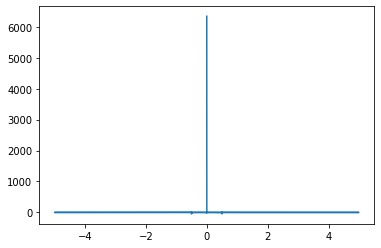

In [51]:
import scipy

N = len(analog_voltage)
T = 1 / SAMPLES_PER_SECOND

